In [1]:
! pwd

/home/bsherwin51/Renaissance/Void


In [2]:
import h5py as h

In [3]:
ds = h.File('catalog.h5')
print(ds)

<HDF5 file "catalog.h5" (mode r)>


In [4]:
print(len(ds.keys())) # only 168 halos now

89


In [5]:
for key in ds.keys():
    print(ds[key].keys())
    break

<KeysViewHDF5 ['M_HI', 'M_HII', 'Mstar', 'Mstar_pop2', 'Mstar_pop2_young', 'Mstar_pop3', 'Nesc', 'Ntot', 'NumberOfPop2Stars', 'NumberOfPop3Stars', 'SFR', 'center', 'fesc', 'fgas', 'fstar', 'mass', 'redshift', 'rvir']>


In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
all_groups = {}
fescs = []
groups = []
fgases = []
masses = []
SFRs = [] 
Mstars = []
redshifts = []
for halo in ds.keys(): # loops through halos
    fesc_list = list(ds[halo]['fesc'])
    fgas_list = list(ds[halo]['fgas'])
    mass_list = list(ds[halo]['mass'])
    SFR_list = list(ds[halo]['SFR'])
    Mstar_list = list(ds[halo]['Mstar'])
    redshift_list = list(ds[halo]['redshift'])    
    for index, fesc in enumerate(fesc_list):# loops thru timestep
        if fesc <= 0.01:
            group = 0
        elif 0.01 < fesc <= 0.10:
            group = 1
        elif 0.10 < fesc <= 0.25:
            group = 2
        else:
            group = 3
        # used enumerate to find index and only use "good" values
        if fesc >= 1e-5:
            fescs.append(fesc)
            groups.append(group)
            fgases.append(ds[halo]['fgas'][index])
            masses.append(ds[halo]['mass'][index])
            SFRs.append(ds[halo]['SFR'][index])
            Mstars.append(ds[halo]['Mstar'][index])
            redshifts.append(ds[halo]['redshift'][index])
    all_groups[halo] = groups

# Sanity check: All parameter arrays should be same size
print(len(fescs), len(fgases), len(masses), len(SFRs), len(Mstars), len(redshifts)) # length is 3122 for all

# Sanity check 2: Length of all_groups should be same as number of halos
print(len(ds.keys()) == len(all_groups)) # length is 168




800 800 800 800 800 800
True


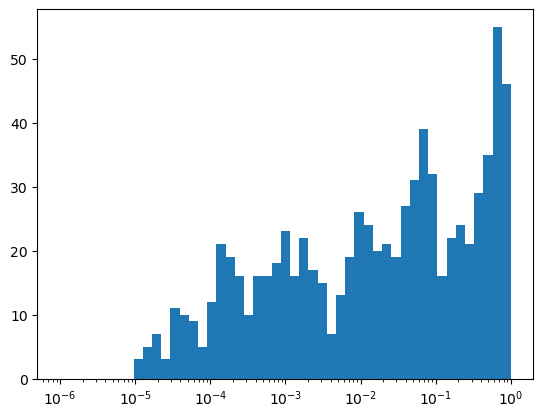

In [8]:
plt.hist(fescs, bins = np.logspace(-6, 0))
plt.xscale('log')

## Architecture

In [10]:
import torch 
import torch.nn as nn
import numpy as np
import sys, os, time
import optuna # Optimizer

In [11]:
# 1 hidden layer code

# inp ---------> size of input data
# h1 ----------> size of first hidden layer
# out ---------> size of output data
# dr ----------> dropout rate
class model_1hl(nn.Module):
    
    def __init__(self, inp, h1, out, dr):
        super(model_1hl, self).__init__()

        self.fc1 = nn.Linear(inp, h1) # lin trans
        self.fc2 = nn.Linear(h1,  out)
        
        self.dropout   = nn.Dropout(p=dr) #normalizes by zeroing at random
        self.ReLU      = nn.ReLU() # RELU(x) = max(0,x)
        self.LeakyReLU = nn.LeakyReLU(0.2) # LeakyReLU = max(0,x) + neg_slope * min(0,x)
        
        # initialize the weights of the different layers
        for m in self.modules(): 
            if isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm1d): # if module is Batch normalization: y = gamma*(x -  E(x))/sqrt(Var(x) + eps) + b
                nn.init.constant_(m.weight, 1) 
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                 '''if module is 3D Convolution: over an input signal composed of several input planes. or ConvTranspose2d Applies a 3D transposed convolution operator over an input image composed of several input planes. The transposed convolution operator multiplies each input value element-wise by a learnable kernel, and sums over the outputs from all input feature planes. Or Lin Trans'''
                 nn.init.kaiming_normal_(m.weight) # normalization that makes extremely deep models (>30 layers) to converge
       
    # forward pass
    def forward(self, x):
        out = self.dropout(self.LeakyReLU(self.fc1(x))) # Apply leakyRELU on input and dropout normalize
        out = self.fc2(out) 
        # out = nn.Softmax(out)
        return out


In [12]:
# N hidden layer code, similar structure to above but generalized
def dynamic_model2(input_size, output_size, n_layers, hidden, dr):

    # define the tuple containing the different layers
    layers = []

    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = hidden[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Dropout(dr[i]))
        in_features = out_features

    # get the last layer
    layers.append(nn.Linear(out_features, output_size))

    # return the model
    return nn.Sequential(*layers)

#model = dynamic_model2(numFeatures, outSize, numHL, [h1, h2], [dr1, dr1])

## Data

In [129]:
from random import shuffle
import torch 
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import sys, os, time, h5py
from pathlib import Path

In [130]:
def normalize_data(data, labels):
    ######################
    # normalize input
    ## the id's correspond to the id's of the feature array you made using vstack in read_data()
    data[:,0]  = (data[:,0] - np.mean(data[:,0]))/np.std(data[:,0]) # Z Scores
    data[:,1]  = (data[:,1] - np.mean(data[:,1]))/np.std(data[:,1])
    data[:,2]  = (data[:,2] - np.mean(data[:,2]))/np.std(data[:,2])
    data[:,3]  = (data[:,3] - np.mean(data[:,3]))/np.std(data[:,3])
    data[:,4]  = (data[:,4] - np.mean(data[:,4]))/np.std(data[:,4])

    ######################
    # normalize labels
    print ("labels", labels)

    # # array = np.log10(labels) # Since labels are large log them
    # print("labels array", array)
    # labels = array
    
    return data, labels

In [131]:
# read data and get training, validation or testing sets
# fin ---------> file with the data
# seed --------> random seed used to split among different datasets
# mode --------> 'train', 'valid', 'test' or 'all'
# normalize ---> whether to normalize the data or not
def read_data(fin, seed, mode, normalize): #fin for h5
    File = 'catalog.h5'
    f     = h5py.File(fin, 'r')
    masses = []
    fgases = []
    SFRs = []
    Mstars = []
    redshifts = []
    fescs = []
    groups = []
    for halo in f.keys():
        fesc_list = list(f[halo]['fesc']) 
        for index, fesc in enumerate(fesc_list):
            if fesc <= 0.01:
                group = 0
            elif 0.01 < fesc <= 0.10:
                group = 1
            elif 0.10 < fesc <= 0.25:
                group = 2
            else:
                group = 3
                
            if fesc >= 1e-5:
                masses.append(f[halo]['mass'][index])
                fgases.append(f[halo]['fgas'][index])
                SFRs.append(f[halo]['SFR'][index])
                Mstars.append(f[halo]['Mstar'][index])
                redshifts.append(f[halo]['redshift'][index])
                fescs.append(fesc)
                groups.append(group)  
    # min_SFR = np.min(SFRs[SFRs != 0])
    minsfr = 100
    for each in SFRs:
        if each < minsfr and each != 0.:
            minsfr = each
    new_SFRs = []
    for SFR in SFRs:
        if SFR == 0.0:
            new_SFRs.append(minsfr*0.9)
        else:
            new_SFRs.append(SFR)        
    # normalize data - EDIT
    ## anything not on order 10^0 - 10^1 should be logged
    masses = np.log10(masses)
    SFRs = np.log10(new_SFRs)
    Mstars = np.log10(Mstars)
    fgases = np.log10(fgases)
    
    # get data, labels and number of elements
    data = np.vstack([SFRs, Mstars, masses, redshifts, fgases]).T # THESE ARE YOUR CHOSEN INPUT VARIABLES
    
    labels = np.array(groups, dtype = 'int')
    print("labels.shape", labels.shape)
    # labels = fluxes.reshape((fluxes.shape[0], fluxSize))
    elements = data.shape[0]
    
    # normalize data
    if normalize:  data, labels = normalize_data(data, labels)

    # get the size and offset depending on the type of dataset
    if   mode=='train':   size, offset = int(elements*0.70), int(elements*0.00)
    elif mode=='valid':   size, offset = int(elements*0.15), int(elements*0.70)
    elif mode=='test':    size, offset = int(elements*0.15), int(elements*0.85)
    elif mode=='all':     size, offset = int(elements*1.00), int(elements*0.00)
    else:                 raise Exception('Wrong name!')

    # randomly shuffle the cubes. Instead of 0 1 2 3...999 have a 
    # random permutation. E.g. 5 9 0 29...342
    np.random.seed(seed)
    indexes = np.arange(elements) 
    np.random.shuffle(indexes)
    indexes = indexes[offset:offset+size] #select indexes of mode

    return data[indexes], labels[indexes]



In [132]:
class make_dataset():

    def __init__(self, mode, seed, fin):

        # get data
        inp, out = read_data(fin, seed, mode, normalize=True)

        # get the corresponding bottlenecks and parameters
        self.size   = inp.shape[0]
        self.input  = torch.tensor(inp, dtype=torch.float32)
        self.output = torch.tensor(out, dtype= torch.long)
        
        print ("size of input and output", np.shape(self.input), np.shape(self.output))
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [133]:
def create_dataset(mode, seed, fin, batch_size, shuffle):
    data_set = make_dataset(mode, seed, fin)
    dataset_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return dataset_loader

## Main

In [318]:
fin = 'catalog.h5'
dataname = 'Void'      # Nickname for data
seed = 20                # remember this to reproduce split
numFeatures = 5         # number of input properties
outSize = 4          # size of wavelength array
featurelist = 'SFRs, Mstars, masses, redshifts, fgases'

# OPTUNA HYPERPARMETERS
numHL = 4           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_1 = 184           # nodes in second hidden layer
h2_1 = 233
h3_1 = 485
h4_1 = 453
dr1_1 = 0.6257722022786032
dr2_1 = 0.5640014992107161
dr3_1 = 0.6690146484827535
dr4_1 = 0.34893234088243874
lr_1 = 0.0007864073846954546
wd_1 = 0.0009484897623137635

Trial 29 finished with value: 0.9375256299972534 and parameters: {'n_layers': 4, 'n_units_l0': 184, 'dropout_l0': 0.6257722022786032, 'n_units_l1': 233, 'dropout_l1': 0.5640014992107161, 'n_units_l2': 485, 'dropout_l2': 0.6690146484827535, 'n_units_l3': 453, 'dropout_l3': 0.34893234088243874, 'lr': 0.0007864073846954546, 'wd': 0.0009484897623137635}. Best is trial 29 with value: 0.9375256299972534.

In [327]:
numHL = 4           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_2 = 159           # nodes in second hidden layer
h2_2 = 261
h3_2 = 498
h4_2 = 341
dr1_2 = 0.5247732081212401
dr2_2 = 0.5428883160494038
dr3_2 = 0.6662457074562445
dr4_2 = 0.35999223637030997
lr_2 = 0.0003355601280247053
wd_2 = 9.813791728274744e-05

Trial 9 finished with value: 0.9590115547180176 and parameters: {'n_layers': 4, 'n_units_l0': 159, 'dropout_l0': 0.5247732081212401, 'n_units_l1': 261, 'dropout_l1': 0.5428883160494038, 'n_units_l2': 498, 'dropout_l2': 0.6662457074562445, 'n_units_l3': 341, 'dropout_l3': 0.35999223637030997, 'lr': 0.0003355601280247053, 'wd': 9.813791728274744e-05}. Best is trial 9 with value: 0.9590115547180176.

In [331]:
numHL = 4           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_3 = 386           # nodes in second hidden layer
h2_3 = 15
h3_3 = 446
h4_3 = 74
dr1_3 = 0.22146227346999917
dr2_3 = 0.4856314874186121
dr3_3 = 0.6422955923882226
dr4_3 = 0.27299236681040545
lr_3 = 0.00021664429271704198
wd_3 = 0.03585248197278107

Trial 8 finished with value: 0.9592313766479492 and parameters: {'n_layers': 4, 'n_units_l0': 386, 'dropout_l0': 0.22146227346999917, 'n_units_l1': 15, 'dropout_l1': 0.4856314874186121, 'n_units_l2': 446, 'dropout_l2': 0.6422955923882226, 'n_units_l3': 74, 'dropout_l3': 0.27299236681040545, 'lr': 0.00021664429271704198, 'wd': 0.03585248197278107}. Best is trial 8 with value: 0.9592313766479492.

In [317]:
h1_non = 150
h2_non = 150
numHL_non = 2
# # # dr1 = 0.20103              # dropout rate for layer 1
dr1_non = 0.35
# # # training parameters
batch_size = 80
# # # lr         = 1.404e-3     (learning rate)
lr_non = 0.001
epochs     = 1000
# # # wd         = 1.195e-6
wd_non = wd

In [319]:
# name of output files


name   = "Normal_dynamicmodel2"
device = torch.device('cpu')
# define loss function
criterion = nn.CrossEntropyLoss()  # MSE or Cross Entropy

# get train, validation, and test sets
print('preparing dataset...')
train_loader = create_dataset('train', seed, fin, batch_size, True)
valid_loader = create_dataset('valid', seed, fin, batch_size, False)
test_loader  = create_dataset('test',  seed, fin, batch_size, False)



preparing dataset...
labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1

In [336]:
#model_non = dynamic_model2(numFeatures, outSize, numHL_non, [h1_non, h2_non], [dr1_non, dr1_non])
model = dynamic_model2(numFeatures, outSize, numHL, [h1_2, h2_2, h3_2, h4_2], [dr1_2, dr2_2, dr3_2, dr4_2])

In [337]:
fout   = 'test_optuna2.txt'
fmodel = 'test_optuna2.pt'
#casts parameters/buffers to specified gpu
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_2, betas=(0.5, 0.999), 
                             weight_decay=wd_2)	


# load best-model, if it exists
'''
if os.path.exists(fmodel):  
    print('Loading model...')
    model.load_state_dict(torch.load(fmodel))
# get validation loss
print('Computing initial validation loss')
model.eval()
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
    with torch.no_grad():
        x    = x.to(device=device)
        y    = y.to(device=device)
        y_NN = model(x)
        min_valid_loss += (criterion(y_NN, y).item())*x.shape[0]
        points += x.shape[0]
min_valid_loss /= points
print('Initial valid loss = %.3e'%min_valid_loss)
'''
# see if results for this model are available (if you're continuing training on a model)
'''
if os.path.exists(fout):  
    dumb = np.loadtxt(fout, skiprows = 11, unpack=False)
    if dumb.size == 0:
        offset = 0
    else: offset = int(dumb[:,0][-1]+1)
else:   offset = 0
'''

# do a loop over all epochs
start = time.time()
min_valid_loss = 1000
for epoch in range(epochs):
    # do training
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_NN = model(x)
        #y = nn.Softmax(y)
        #y_NN = nn.Softmax(y_NN)
        loss = criterion(y_NN, y)
        train_loss += (loss.item())*x.shape[0]
        points     += x.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= points

    # do testing
    test_loss, points = 0.0, 0
    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            test_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
    test_loss /= points
    
    # save model if it is better
    if test_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = test_loss
        print('%03d %.3e %.3e (saving)'%(epoch, train_loss, test_loss))
    else:
        print('%03d %.3e %.3e'%(epoch, train_loss, test_loss))
    
    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
    f.close()
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 344717
000 1.334e+00 1.307e+00 (saving)
001 1.257e+00 1.227e+00 (saving)
002 1.170e+00 1.141e+00 (saving)
003 1.125e+00 1.095e+00 (saving)
004 1.095e+00 1.075e+00 (saving)
005 1.073e+00 1.063e+00 (saving)
006 1.058e+00 1.054e+00 (saving)
007 1.030e+00 1.046e+00 (saving)
008 1.041e+00 1.044e+00 (saving)
009 1.040e+00 1.039e+00 (saving)
010 1.030e+00 1.036e+00 (saving)
011 1.034e+00 1.035e+00 (saving)
012 1.026e+00 1.036e+00
013 1.035e+00 1.034e+00 (saving)
014 1.011e+00 1.034e+00
015 1.009e+00 1.030e+00 (saving)
016 1.004e+00 1.029e+00 (saving)
017 1.009e+00 1.032e+00
018 1.001e+00 1.035e+00
019 1.013e+00 1.037e+00
020 9.995e-01 1.029e+00
021 9.910e-01 1.032e+00
022 1.004e+00 1.036e+00
023 1.002e+00 1.031e+00
024 1.013e+00 1.031e+00
025 1.009e+00 1.035e+00
026 9.908e-01 1.032e+00
027 9.949e-01 1.034e+00
028 9.859e-01 1.031e+00
029 9.910e-01 1.032e+00
030 9.801e-01 1.032e+00
031 9.950e-01 1.034e+00
032 9.704e-01 1.034e+00
033 9.918e-01 1.032e+00


In [338]:
losses_1 = np.loadtxt('test_optuna1.txt', delimiter = ' ')   
train_losses_1 = losses_1[:,1]  
test_losses_1 = losses_1[:, 2]

losses_2 = np.loadtxt('test_optuna2.txt', delimiter = ' ')   
train_losses_2 = losses_2[:,1]  
test_losses_2 = losses_2[:, 2]

losses_3 = np.loadtxt('test_optuna3.txt', delimiter = ' ')   
train_losses_3 = losses_3[:,1]  
test_losses_3 = losses_3[:, 2]

# losses_non = np.loadtxt('test_new_non50epoch.txt', delimiter = ' ')
# train_losses_non = losses_non[:,1]
# test_losses_non = losses_non[:, 2]

Text(0, 0.5, 'Loss')

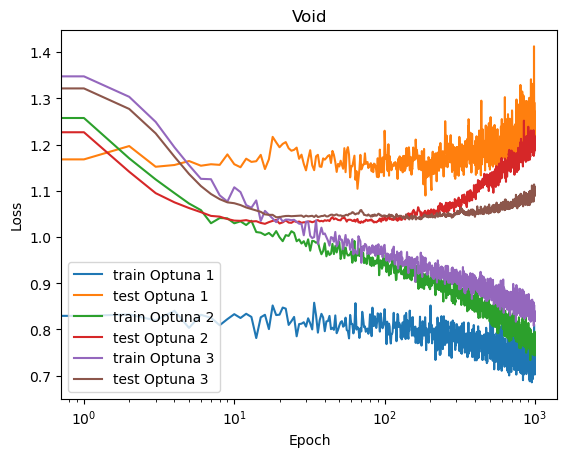

In [339]:
import matplotlib.pyplot as plt
plt.plot(train_losses_1, label = 'train Optuna 1')
plt.plot(test_losses_1, label = 'test Optuna 1')
plt.plot(train_losses_2, label = 'train Optuna 2')
plt.plot(test_losses_2, label = 'test Optuna 2')
plt.plot(train_losses_3, label = 'train Optuna 3')
plt.plot(test_losses_3, label = 'test Optuna 3')
# plt.plot(train_losses_non, label = 'train no Optuna')
# plt.plot(test_losses_non, label = 'test no Optuna')
plt.xscale('log')
#plt.ylim(0.6,1.3)
plt.legend()
plt.title("Void")
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Optuna

In [302]:
fout   = 'test_non_valid.txt'
fmodel = 'test_new_valid.pt'
#casts parameters/buffers to specified gpu
model_non.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model_non.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model_non.parameters(), lr=lr_non, betas=(0.5, 0.999), 
                             weight_decay=wd_non)	


# load best-model, if it exists
'''
if os.path.exists(fmodel):  
    print('Loading model...')
    model.load_state_dict(torch.load(fmodel))
# get validation loss
print('Computing initial validation loss')
model.eval()
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
    with torch.no_grad():
        x    = x.to(device=device)
        y    = y.to(device=device)
        y_NN = model(x)
        min_valid_loss += (criterion(y_NN, y).item())*x.shape[0]
        points += x.shape[0]
min_valid_loss /= points
print('Initial valid loss = %.3e'%min_valid_loss)
'''
# see if results for this model are available (if you're continuing training on a model)
'''
if os.path.exists(fout):  
    dumb = np.loadtxt(fout, skiprows = 11, unpack=False)
    if dumb.size == 0:
        offset = 0
    else: offset = int(dumb[:,0][-1]+1)
else:   offset = 0
'''

# do a loop over all epochs
start = time.time()
min_valid_loss = 1000
for epoch in range(epochs):    
    # do training
    train_loss, points = 0.0, 0
    model_non.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_NN = model_non(x)
        #y = nn.Softmax(y)
        #y_NN = nn.Softmax(y_NN)
        loss = criterion(y_NN, y)
        train_loss += (loss.item())*x.shape[0]
        points     += x.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= points

    # do testing
    test_loss, points = 0.0, 0
    model_non.eval()
    for x, y in test_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model_non(x)
            #y_NN = nn.Softmax(y_NN)
            test_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
    test_loss /= points
    
    # save model if it is better
    if test_loss<min_valid_loss:
        torch.save(model_non.state_dict(), fmodel)
        min_valid_loss = test_loss
        print('%03d %.3e %.3e (saving)'%(epoch, train_loss, test_loss))
    else:
        print('%03d %.3e %.3e'%(epoch, train_loss, test_loss))
    
    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
    f.close()
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 24154
000 1.157e+00 1.083e+00 (saving)
001 1.038e+00 1.047e+00 (saving)
002 1.028e+00 1.047e+00 (saving)
003 1.015e+00 1.059e+00
004 9.777e-01 1.071e+00
005 9.885e-01 1.057e+00
006 9.797e-01 1.053e+00
007 9.569e-01 1.083e+00
008 9.595e-01 1.056e+00
009 9.696e-01 1.059e+00
010 9.589e-01 1.048e+00
011 9.513e-01 1.111e+00
012 9.667e-01 1.085e+00
013 9.462e-01 1.045e+00 (saving)
014 9.375e-01 1.072e+00
015 9.529e-01 1.058e+00
016 9.358e-01 1.058e+00
017 9.607e-01 1.069e+00
018 9.284e-01 1.052e+00
019 9.253e-01 1.077e+00
020 9.245e-01 1.076e+00
021 9.268e-01 1.076e+00
022 9.115e-01 1.065e+00
023 9.230e-01 1.088e+00
024 9.168e-01 1.063e+00
025 9.215e-01 1.061e+00
026 9.105e-01 1.060e+00
027 9.159e-01 1.060e+00
028 9.063e-01 1.087e+00
029 9.059e-01 1.077e+00
030 9.149e-01 1.066e+00
031 9.078e-01 1.074e+00
032 9.119e-01 1.069e+00
033 8.943e-01 1.059e+00
034 9.009e-01 1.076e+00
035 9.044e-01 1.074e+00
036 9.112e-01 1.063e+00
037 9.003e-01 1.062e+00
038 

In [62]:
def dynamic_model(trial, input_size, output_size, max_layers=3, max_neurons_layers=500):
    # define the tuple containing the different layers
    layers = []
    # get the number of hidden layers
    n_layers = trial.suggest_int("n_layers", 1, max_layers)
    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, max_neurons_layers)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.8)
        layers.append(nn.Dropout(p))
        in_features = out_features
    # get the last layer
    layers.append(nn.Linear(out_features, output_size))
    # return the model
    return nn.Sequential(*layers)

In [63]:
import numpy as np
import sys, os, time
import torch
import torch.nn as nn
import optuna
import h5py

In [312]:
class Objective(object):
    def __init__(self, input_size, output_size, max_layers, max_neurons_layers, device,
                 epochs, seed, batch_size):

        self.input_size         = input_size
        self.output_size        = output_size
        self.max_layers         = max_layers
        self.max_neurons_layers = max_neurons_layers
        self.device             = device
        self.epochs             = epochs
        self.seed               = seed
        self.batch_size         = batch_size

    def __call__(self, trial):

        # name of the files that will contain the losses and model weights
        f1 = 'losses_%s'%prefix
        f2 = 'models_%s'%prefix
        if not(os.path.exists(f1)):  os.system('mkdir %s'%f1)
        if not(os.path.exists(f2)):  os.system('mkdir %s'%f2)

        fout   = 'losses_%s/loss_%d.txt'%(prefix, trial.number)
        fmodel = 'models_%s/model_%d.pt'%(prefix, trial.number)
        
        dataname = 'fesc_test' # name of your dataset, for the loss file header
        
        # write properties & headers in case you need to refer in the future and you've changed the main.py file
        f = open(fout, 'w')
        f.write('training dataset: {}\n'.format(dataname))
        f.write('seed = {}\numFeatures = {}\nFeature List: {}\nfluxSize = {}\nbatch_size = {}\nepochs     = {}\n'.format(seed, input_size, features, output_size, batch_size, epochs))
        f.write('0 epoch  1 train loss  2 test loss\n')
        f.close()

        # generate the architecture
        model = dynamic_model(trial, self.input_size, self.output_size, 
                            self.max_layers, self.max_neurons_layers).to(self.device)

        # get the weight decay and learning rate values
        ## adjust boundary values as needed
        lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
        wd = trial.suggest_float("wd", 1e-6, 1e-1,  log=True)

        # define the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.5, 0.999), 
                                      weight_decay=wd)

        # define loss function
        criterion = nn.CrossEntropyLoss() 

        # get the data
        train_loader = create_dataset('train', self.seed, fin, self.batch_size, True)
        valid_loader = create_dataset('valid', self.seed, fin, self.batch_size, False)
        test_loader  = create_dataset('test',  self.seed, fin, self.batch_size, False)

        # train/validate model
        min_valid = 1e40
        for epoch in range(self.epochs):

            # training
            train_loss, points = 0.0, 0
            model.train()
            for x, y in train_loader:
                x, y = x.to(self.device), y.to(self.device)
                y_NN = model(x)
                
                loss = criterion(y_NN, y)
                train_loss += (loss.item())*x.shape[0]
                points     += x.shape[0]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss /= points
            '''
            # validation
            valid_loss, points = 0.0, 0
            model.eval()
            with torch.no_grad():
                for x, y in valid_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    y_NN = model(x)
                    valid_loss += (criterion(y_NN, y).item())*x.shape[0]
                    points     += x.shape[0]
            valid_loss /= points
            '''
            # do testing
            test_loss, points = 0.0, 0
            model.eval()
            for x, y in test_loader:
                with torch.no_grad():
                    x    = x.to(device)
                    y    = y.to(device)
                    y_NN = model(x)
                    test_loss += (criterion(y_NN, y).item())*x.shape[0]
                    points    += x.shape[0]
            test_loss /= points
            
            #save this model if it's better
            if test_loss<min_valid:  
                min_valid = test_loss
                torch.save(model.state_dict(), fmodel)
            f = open(fout, 'a')
            f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
            f.close()

            # Handle pruning based on the intermediate value
            # comment out these lines if using pruning
            #trial.report(min_valid, epoch)
            #if trial.should_prune():  raise optuna.exceptions.TrialPruned()

        return min_valid


In [315]:
##################################### INPUT ##########################################
# data parameters
fin      = 'catalog.h5' # file containing your global properties
features = 'SFRs, Mstars, masses, redshifts, fgases' # writing the order of input data as per data.py. Modify as needed
f_features_norm = None
f_labels  = 'fesc_test.txt' # file containing output SEDs
seed      = 5

# optuna architecture parameters
input_size         = 5 # number of input global properties
output_size        = 4 # size of SED/wavelength array
max_layers         = 5 # max number of hidden layers to test out
max_neurons_layers = 500 # max number of nodes per hidden layer to test out

# training parameters
batch_size = 80
epochs     = 1000

# optuna parameters -- modify as needed
prefix    = 'inp{}out{}maxl{}maxn{}bs{}ep{}'.format(input_size, output_size, max_layers, max_neurons_layers, batch_size, epochs)
study_name       = 'fesc_new' 
n_trials         = 50 # set to None for infinite
storage          = 'sqlite:///fesc_%s.db'%prefix 
n_jobs           = 1
n_startup_trials = 30 # random sample the hyperparameter space before running the model sampler
#########################


In [316]:
device = torch.device('cpu')

# define the optuna study and optimize it
objective = Objective(input_size, output_size, max_layers, max_neurons_layers, 
                      device, epochs, seed, batch_size)
sampler = optuna.samplers.TPESampler(n_startup_trials=n_startup_trials)
study = optuna.create_study(study_name=study_name, sampler=sampler, storage=storage,
                            load_if_exists=True)
study.optimize(objective, n_trials, n_jobs=n_jobs)


[I 2023-06-06 12:46:59,874] A new study created in RDB with name: fesc_new


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:47:27,464] Trial 0 finished with value: 1.0693001349767048 and parameters: {'n_layers': 1, 'n_units_l0': 428, 'dropout_l0': 0.7397963302286334, 'lr': 4.152534321451345e-06, 'wd': 9.109891019782786e-06}. Best is trial 0 with value: 1.0693001349767048.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:48:15,256] Trial 1 finished with value: 1.335445483525594 and parameters: {'n_layers': 5, 'n_units_l0': 251, 'dropout_l0': 0.3730472443446949, 'n_units_l1': 30, 'dropout_l1': 0.7566377624121616, 'n_units_l2': 434, 'dropout_l2': 0.716270832959568, 'n_units_l3': 32, 'dropout_l3': 0.4475863251288258, 'n_units_l4': 274, 'dropout_l4': 0.5602968015682623, 'lr': 1.0145272390078158e-06, 'wd': 0.001333521016169971}. Best is trial 0 with value: 1.0693001349767048.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:48:51,505] Trial 2 finished with value: 1.0220099687576294 and parameters: {'n_layers': 3, 'n_units_l0': 246, 'dropout_l0': 0.45695367280682586, 'n_units_l1': 195, 'dropout_l1': 0.22758559858187793, 'n_units_l2': 165, 'dropout_l2': 0.559172155810927, 'lr': 3.178216482764789e-05, 'wd': 0.00026956082777224416}. Best is trial 2 with value: 1.0220099687576294.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:49:36,862] Trial 3 finished with value: 1.2737744251887004 and parameters: {'n_layers': 4, 'n_units_l0': 311, 'dropout_l0': 0.624340421298557, 'n_units_l1': 58, 'dropout_l1': 0.606103854130787, 'n_units_l2': 124, 'dropout_l2': 0.7827205657201106, 'n_units_l3': 371, 'dropout_l3': 0.7099241150883415, 'lr': 1.9170211598758475e-06, 'wd': 0.03723422520991374}. Best is trial 2 with value: 1.0220099687576294.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:49:58,599] Trial 4 finished with value: 1.1700419584910076 and parameters: {'n_layers': 1, 'n_units_l0': 151, 'dropout_l0': 0.6021588366927717, 'lr': 1.6191284108308229e-06, 'wd': 3.6132595090747966e-05}. Best is trial 2 with value: 1.0220099687576294.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:50:19,829] Trial 5 finished with value: 1.0218538443247478 and parameters: {'n_layers': 1, 'n_units_l0': 21, 'dropout_l0': 0.38212048026058654, 'lr': 0.00017635179619386937, 'wd': 0.00020436017987844138}. Best is trial 5 with value: 1.0218538443247478.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:51:13,537] Trial 6 finished with value: 1.0442524751027424 and parameters: {'n_layers': 5, 'n_units_l0': 193, 'dropout_l0': 0.5198405802164907, 'n_units_l1': 132, 'dropout_l1': 0.6215841066374301, 'n_units_l2': 219, 'dropout_l2': 0.7077281822272543, 'n_units_l3': 118, 'dropout_l3': 0.523753629848853, 'n_units_l4': 412, 'dropout_l4': 0.26844560760006764, 'lr': 9.371379082606035e-06, 'wd': 0.0003127819307208906}. Best is trial 5 with value: 1.0218538443247478.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:52:20,118] Trial 7 finished with value: 1.0193997224171956 and parameters: {'n_layers': 5, 'n_units_l0': 183, 'dropout_l0': 0.26121748869476646, 'n_units_l1': 375, 'dropout_l1': 0.3828791117249078, 'n_units_l2': 173, 'dropout_l2': 0.7378851310362706, 'n_units_l3': 392, 'dropout_l3': 0.5984794899405301, 'n_units_l4': 231, 'dropout_l4': 0.6794066177621607, 'lr': 1.3610638919597157e-05, 'wd': 6.755261540195847e-05}. Best is trial 7 with value: 1.0193997224171956.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:52:59,156] Trial 8 finished with value: 0.9592313766479492 and parameters: {'n_layers': 4, 'n_units_l0': 386, 'dropout_l0': 0.22146227346999917, 'n_units_l1': 15, 'dropout_l1': 0.4856314874186121, 'n_units_l2': 446, 'dropout_l2': 0.6422955923882226, 'n_units_l3': 74, 'dropout_l3': 0.27299236681040545, 'lr': 0.00021664429271704198, 'wd': 0.03585248197278107}. Best is trial 8 with value: 0.9592313766479492.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:54:07,064] Trial 9 finished with value: 0.9590115547180176 and parameters: {'n_layers': 4, 'n_units_l0': 159, 'dropout_l0': 0.5247732081212401, 'n_units_l1': 261, 'dropout_l1': 0.5428883160494038, 'n_units_l2': 498, 'dropout_l2': 0.6662457074562445, 'n_units_l3': 341, 'dropout_l3': 0.35999223637030997, 'lr': 0.0003355601280247053, 'wd': 9.813791728274744e-05}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:54:48,764] Trial 10 finished with value: 1.03741188844045 and parameters: {'n_layers': 4, 'n_units_l0': 251, 'dropout_l0': 0.36903823297082194, 'n_units_l1': 64, 'dropout_l1': 0.24726805440064406, 'n_units_l2': 268, 'dropout_l2': 0.6809607967554786, 'n_units_l3': 33, 'dropout_l3': 0.6416676280003526, 'lr': 1.866532841608878e-05, 'wd': 6.171267118631492e-06}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:55:28,628] Trial 11 finished with value: 0.9851419528325399 and parameters: {'n_layers': 2, 'n_units_l0': 315, 'dropout_l0': 0.44150714451204615, 'n_units_l1': 226, 'dropout_l1': 0.6505849045339402, 'lr': 0.0002479083066930721, 'wd': 3.1953321741679764e-05}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:56:04,592] Trial 12 finished with value: 0.9744935830434164 and parameters: {'n_layers': 3, 'n_units_l0': 285, 'dropout_l0': 0.20560152938934684, 'n_units_l1': 80, 'dropout_l1': 0.45564975099629323, 'n_units_l2': 413, 'dropout_l2': 0.7280169270589554, 'lr': 0.0006216416327055025, 'wd': 0.00398432944371288}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:56:23,642] Trial 13 finished with value: 1.032341202100118 and parameters: {'n_layers': 1, 'n_units_l0': 29, 'dropout_l0': 0.26856864666398117, 'lr': 0.0006890614779213638, 'wd': 0.000539360564922965}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:57:17,010] Trial 14 finished with value: 1.0077719688415527 and parameters: {'n_layers': 4, 'n_units_l0': 338, 'dropout_l0': 0.5026922639566924, 'n_units_l1': 436, 'dropout_l1': 0.7737267805095907, 'n_units_l2': 134, 'dropout_l2': 0.38583232972750536, 'n_units_l3': 12, 'dropout_l3': 0.670919070096669, 'lr': 5.050336214096479e-05, 'wd': 0.00036509976383985695}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:58:04,390] Trial 15 finished with value: 1.018265167872111 and parameters: {'n_layers': 5, 'n_units_l0': 96, 'dropout_l0': 0.2611152961983261, 'n_units_l1': 386, 'dropout_l1': 0.7229928549523348, 'n_units_l2': 94, 'dropout_l2': 0.40377045148368934, 'n_units_l3': 179, 'dropout_l3': 0.2791114953031033, 'n_units_l4': 13, 'dropout_l4': 0.7561808429360692, 'lr': 1.7068947749147845e-05, 'wd': 0.0001851751134600027}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:58:53,139] Trial 16 finished with value: 1.1023611227671306 and parameters: {'n_layers': 4, 'n_units_l0': 468, 'dropout_l0': 0.3756490567686197, 'n_units_l1': 229, 'dropout_l1': 0.24008174392986886, 'n_units_l2': 120, 'dropout_l2': 0.35641779952200603, 'n_units_l3': 149, 'dropout_l3': 0.3648681731042329, 'lr': 1.0674324395989647e-06, 'wd': 1.7211691188834234e-05}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 12:59:53,772] Trial 17 finished with value: 1.027185042699178 and parameters: {'n_layers': 4, 'n_units_l0': 276, 'dropout_l0': 0.40627659102512853, 'n_units_l1': 273, 'dropout_l1': 0.4249932479380282, 'n_units_l2': 224, 'dropout_l2': 0.39694640157767236, 'n_units_l3': 427, 'dropout_l3': 0.3196967343944089, 'lr': 1.4705571619378295e-05, 'wd': 1.2434205883511604e-05}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:01:28,364] Trial 18 finished with value: 1.0138309001922607 and parameters: {'n_layers': 5, 'n_units_l0': 72, 'dropout_l0': 0.30351770963486285, 'n_units_l1': 431, 'dropout_l1': 0.4304137799089697, 'n_units_l2': 500, 'dropout_l2': 0.5373386174672194, 'n_units_l3': 268, 'dropout_l3': 0.5437734170334099, 'n_units_l4': 261, 'dropout_l4': 0.6851001217579542, 'lr': 2.5249316628914976e-05, 'wd': 0.001416146235604588}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:02:18,166] Trial 19 finished with value: 0.9811494747797648 and parameters: {'n_layers': 5, 'n_units_l0': 125, 'dropout_l0': 0.42915579489567024, 'n_units_l1': 127, 'dropout_l1': 0.7066865097354464, 'n_units_l2': 295, 'dropout_l2': 0.4037369817124391, 'n_units_l3': 103, 'dropout_l3': 0.6424220844019837, 'n_units_l4': 89, 'dropout_l4': 0.4737217284223354, 'lr': 0.00010019989365830719, 'wd': 0.00015199370259067412}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:02:50,453] Trial 20 finished with value: 1.1332018375396729 and parameters: {'n_layers': 3, 'n_units_l0': 131, 'dropout_l0': 0.33886629351050074, 'n_units_l1': 45, 'dropout_l1': 0.7096604565670073, 'n_units_l2': 51, 'dropout_l2': 0.4347134978069088, 'lr': 4.525267929139625e-06, 'wd': 0.0007057345693487177}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:03:11,023] Trial 21 finished with value: 1.0252876281738281 and parameters: {'n_layers': 1, 'n_units_l0': 308, 'dropout_l0': 0.4555635722750212, 'lr': 0.00015243007617602567, 'wd': 4.452654357315271e-05}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:03:32,801] Trial 22 finished with value: 1.207650105158488 and parameters: {'n_layers': 1, 'n_units_l0': 262, 'dropout_l0': 0.5552407135921527, 'lr': 1.0820761068578812e-06, 'wd': 0.0939520230051641}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:03:59,367] Trial 23 finished with value: 1.2475559314092 and parameters: {'n_layers': 3, 'n_units_l0': 57, 'dropout_l0': 0.7984325742419964, 'n_units_l1': 255, 'dropout_l1': 0.70972478764019, 'n_units_l2': 54, 'dropout_l2': 0.6622133249578201, 'lr': 3.016251919768105e-06, 'wd': 1.631464662191725e-05}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:04:23,970] Trial 24 finished with value: 1.0709041357040405 and parameters: {'n_layers': 2, 'n_units_l0': 71, 'dropout_l0': 0.5291170360402027, 'n_units_l1': 4, 'dropout_l1': 0.6971532228266264, 'lr': 0.00024469539992092316, 'wd': 1.6401393609069152e-06}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:04:41,591] Trial 25 finished with value: 1.0221097866694133 and parameters: {'n_layers': 1, 'n_units_l0': 153, 'dropout_l0': 0.3083979741973773, 'lr': 0.0004480021049842132, 'wd': 0.006087688300631402}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:05:11,949] Trial 26 finished with value: 1.0817607243855794 and parameters: {'n_layers': 2, 'n_units_l0': 280, 'dropout_l0': 0.5616341995527143, 'n_units_l1': 217, 'dropout_l1': 0.42845085643747366, 'lr': 1.5676554288500523e-06, 'wd': 1.141819025418797e-05}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:06:04,745] Trial 27 finished with value: 1.0951594511667888 and parameters: {'n_layers': 5, 'n_units_l0': 454, 'dropout_l0': 0.6781647915717652, 'n_units_l1': 327, 'dropout_l1': 0.5487548526413717, 'n_units_l2': 38, 'dropout_l2': 0.5809802880289157, 'n_units_l3': 252, 'dropout_l3': 0.7388292915614181, 'n_units_l4': 44, 'dropout_l4': 0.7560588941321589, 'lr': 7.5687683918494195e-06, 'wd': 0.00012933007322506047}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:07:06,620] Trial 28 finished with value: 0.9793972174326578 and parameters: {'n_layers': 5, 'n_units_l0': 497, 'dropout_l0': 0.4839191117202125, 'n_units_l1': 233, 'dropout_l1': 0.5551826022369185, 'n_units_l2': 208, 'dropout_l2': 0.26694242346648406, 'n_units_l3': 381, 'dropout_l3': 0.3235259446517093, 'n_units_l4': 201, 'dropout_l4': 0.5556095691995924, 'lr': 0.000414281141628478, 'wd': 0.0024208317717435935}. Best is trial 9 with value: 0.9590115547180176.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:08:09,680] Trial 29 finished with value: 0.9375256299972534 and parameters: {'n_layers': 4, 'n_units_l0': 184, 'dropout_l0': 0.6257722022786032, 'n_units_l1': 233, 'dropout_l1': 0.5640014992107161, 'n_units_l2': 485, 'dropout_l2': 0.6690146484827535, 'n_units_l3': 453, 'dropout_l3': 0.34893234088243874, 'lr': 0.0007864073846954546, 'wd': 0.0009484897623137635}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:10:23,349] Trial 30 finished with value: 0.9440099398295084 and parameters: {'n_layers': 4, 'n_units_l0': 387, 'dropout_l0': 0.6799342163067411, 'n_units_l1': 316, 'dropout_l1': 0.5137632110893747, 'n_units_l2': 490, 'dropout_l2': 0.640261639464997, 'n_units_l3': 457, 'dropout_l3': 0.20589699527843666, 'lr': 0.0007760707191465807, 'wd': 0.013482652017353073}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:23:13,811] Trial 31 finished with value: 0.9425084193547567 and parameters: {'n_layers': 4, 'n_units_l0': 377, 'dropout_l0': 0.6882570220506026, 'n_units_l1': 300, 'dropout_l1': 0.5195792130278531, 'n_units_l2': 487, 'dropout_l2': 0.5951821670982651, 'n_units_l3': 469, 'dropout_l3': 0.2080410893915461, 'lr': 0.0009914989084324262, 'wd': 0.013936255590087512}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:24:43,296] Trial 32 finished with value: 0.9503496487935384 and parameters: {'n_layers': 4, 'n_units_l0': 365, 'dropout_l0': 0.6883681296604838, 'n_units_l1': 309, 'dropout_l1': 0.5268621370817197, 'n_units_l2': 492, 'dropout_l2': 0.6252180520934204, 'n_units_l3': 499, 'dropout_l3': 0.20182453778909643, 'lr': 0.0008906482429444953, 'wd': 0.0074181258605915045}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:28:12,308] Trial 33 finished with value: 0.9470399618148804 and parameters: {'n_layers': 3, 'n_units_l0': 393, 'dropout_l0': 0.7071621658379607, 'n_units_l1': 307, 'dropout_l1': 0.5027352354305813, 'n_units_l2': 373, 'dropout_l2': 0.6069286012539091, 'lr': 0.0009867166515527322, 'wd': 0.007543320050928351}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:31:40,820] Trial 34 finished with value: 0.9593643744786581 and parameters: {'n_layers': 3, 'n_units_l0': 412, 'dropout_l0': 0.7174230174263239, 'n_units_l1': 305, 'dropout_l1': 0.4885111146443397, 'n_units_l2': 360, 'dropout_l2': 0.6005055462729815, 'lr': 0.0009470161012219821, 'wd': 0.013428916488829988}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:35:57,178] Trial 35 finished with value: 0.9666944344838461 and parameters: {'n_layers': 3, 'n_units_l0': 412, 'dropout_l0': 0.641939478732675, 'n_units_l1': 365, 'dropout_l1': 0.5860268280765939, 'n_units_l2': 385, 'dropout_l2': 0.5098762845704429, 'lr': 0.0005797728617733207, 'wd': 0.013013385068108967}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:38:08,786] Trial 36 finished with value: 0.9596930742263794 and parameters: {'n_layers': 3, 'n_units_l0': 368, 'dropout_l0': 0.7576898482444467, 'n_units_l1': 184, 'dropout_l1': 0.5078392484429872, 'n_units_l2': 330, 'dropout_l2': 0.6069513404374518, 'lr': 0.0009874836679955826, 'wd': 0.002079600368909815}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:43:04,041] Trial 37 finished with value: 0.9394910335540771 and parameters: {'n_layers': 4, 'n_units_l0': 445, 'dropout_l0': 0.6452010339827356, 'n_units_l1': 481, 'dropout_l1': 0.5756311608404143, 'n_units_l2': 456, 'dropout_l2': 0.570479799520049, 'n_units_l3': 472, 'dropout_l3': 0.21875293567885154, 'lr': 0.0004430021184712112, 'wd': 0.0035043530359914897}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:47:48,899] Trial 38 finished with value: 0.9624772071838379 and parameters: {'n_layers': 4, 'n_units_l0': 212, 'dropout_l0': 0.6468005711796986, 'n_units_l1': 343, 'dropout_l1': 0.583193843295528, 'n_units_l2': 457, 'dropout_l2': 0.5537337866441114, 'n_units_l3': 489, 'dropout_l3': 0.2229012536390888, 'lr': 0.00047597502999149416, 'wd': 0.0008062530231355259}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:52:28,214] Trial 39 finished with value: 0.954733649889628 and parameters: {'n_layers': 4, 'n_units_l0': 443, 'dropout_l0': 0.5922753097269917, 'n_units_l1': 492, 'dropout_l1': 0.6477259004999105, 'n_units_l2': 464, 'dropout_l2': 0.4979460211294333, 'n_units_l3': 449, 'dropout_l3': 0.20270005057533635, 'lr': 0.00032796956631021075, 'wd': 0.0036248059936684423}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:55:02,749] Trial 40 finished with value: 0.9528986612955729 and parameters: {'n_layers': 4, 'n_units_l0': 492, 'dropout_l0': 0.6092993788320369, 'n_units_l1': 497, 'dropout_l1': 0.5672698876316576, 'n_units_l2': 413, 'dropout_l2': 0.6368090069002543, 'n_units_l3': 445, 'dropout_l3': 0.25256945828723093, 'lr': 0.0006315172513225597, 'wd': 0.0013365630977940884}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 13:57:27,812] Trial 41 finished with value: 0.9642053842544556 and parameters: {'n_layers': 4, 'n_units_l0': 390, 'dropout_l0': 0.6638724119334525, 'n_units_l1': 289, 'dropout_l1': 0.5234649335718287, 'n_units_l2': 420, 'dropout_l2': 0.5978971206285569, 'n_units_l3': 461, 'dropout_l3': 0.25417078361015677, 'lr': 0.000720512674140849, 'wd': 0.012213550692261195}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:01:01,107] Trial 42 finished with value: 0.9466829299926758 and parameters: {'n_layers': 3, 'n_units_l0': 224, 'dropout_l0': 0.6965111110989577, 'n_units_l1': 418, 'dropout_l1': 0.6031163253610022, 'n_units_l2': 469, 'dropout_l2': 0.6196169426721873, 'lr': 0.00098448936788733, 'wd': 0.026430635407575346}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:04:01,188] Trial 43 finished with value: 0.9498764276504517 and parameters: {'n_layers': 4, 'n_units_l0': 222, 'dropout_l0': 0.6308906353536341, 'n_units_l1': 446, 'dropout_l1': 0.6124840829527353, 'n_units_l2': 466, 'dropout_l2': 0.6869289860867204, 'n_units_l3': 326, 'dropout_l3': 0.20434404375700949, 'lr': 0.0005217724861127709, 'wd': 0.029814586176420355}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:06:20,478] Trial 44 finished with value: 0.955918550491333 and parameters: {'n_layers': 3, 'n_units_l0': 189, 'dropout_l0': 0.663532708246501, 'n_units_l1': 465, 'dropout_l1': 0.6026316466194757, 'n_units_l2': 437, 'dropout_l2': 0.5619257541603644, 'lr': 0.00035789867748591133, 'wd': 0.022385206063007927}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:09:37,088] Trial 45 finished with value: 0.95306396484375 and parameters: {'n_layers': 4, 'n_units_l0': 358, 'dropout_l0': 0.7311261515134666, 'n_units_l1': 401, 'dropout_l1': 0.5663719712025846, 'n_units_l2': 472, 'dropout_l2': 0.6412536904187276, 'n_units_l3': 412, 'dropout_l3': 0.2933904341287104, 'lr': 0.0007282959644330202, 'wd': 0.06170433467698809}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:11:17,143] Trial 46 finished with value: 0.9605429967244467 and parameters: {'n_layers': 4, 'n_units_l0': 226, 'dropout_l0': 0.6956517495511279, 'n_units_l1': 176, 'dropout_l1': 0.5398317040328121, 'n_units_l2': 389, 'dropout_l2': 0.7176224919479521, 'n_units_l3': 484, 'dropout_l3': 0.25379047343574207, 'lr': 0.0005146457198430839, 'wd': 0.03687889114003678}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:12:12,534] Trial 47 finished with value: 0.9939108689626058 and parameters: {'n_layers': 2, 'n_units_l0': 336, 'dropout_l0': 0.7450735009634288, 'n_units_l1': 402, 'dropout_l1': 0.6194237536584611, 'lr': 0.0003229437403862756, 'wd': 0.021395695967933965}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:14:07,741] Trial 48 finished with value: 0.9438568353652954 and parameters: {'n_layers': 3, 'n_units_l0': 170, 'dropout_l0': 0.6197782221330423, 'n_units_l1': 363, 'dropout_l1': 0.63709011324787, 'n_units_l2': 437, 'dropout_l2': 0.5786634035249684, 'lr': 0.0007427547714410096, 'wd': 0.0038521811691705978}. Best is trial 29 with value: 0.9375256299972534.


labels.shape (800,)
labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 3 2 1 0 1 0 0 0 2 3 3 1 0 0 2 2 2 1 1 0 0 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 2 2 1 0 2 2 2
 0 0 0 1 3 3 2 1 0 1 0 0 1 1 0 1 3 3 3 3 1 1 1 0 0 0 0 0 0 0 0 1 1 2 1 0 0
 3 2 1 0 0 2 2 1 2 2 1 1 3 3 3 0 3 3 3 0 0 3 3 3 3 3 1 0 0 2 3 3 2 3 3 3 3
 3 0 0 0 1 0 0 0 1 3 3 3 3 3 3 1 0 1 2 3 2 2 1 0 3 3 3 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 1 1 1 3 0 1 1 1 0 0 3 1 0 3 3 3 1 3 3 3 3 3 3 2 1 0 1 1 0 3 3
 3 3 3 3 3 3 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 1 0 3 3 3 3 3 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 2 0 0 2 2 2 3 3 0 0 0
 0 1 1 0 3 3 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 2 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 3 3 3 3 3 0 0 1 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 0 0 0 0 0 1 1 0 0 2 2 2 2 0 0 3 3 3 3 3 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 2 3 3 2 2 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 

[I 2023-06-06 14:16:07,082] Trial 49 finished with value: 0.9649011691411337 and parameters: {'n_layers': 4, 'n_units_l0': 173, 'dropout_l0': 0.6132527915869331, 'n_units_l1': 356, 'dropout_l1': 0.6415664331037491, 'n_units_l2': 439, 'dropout_l2': 0.7602314881742748, 'n_units_l3': 423, 'dropout_l3': 0.406333239673941, 'lr': 0.0006093619142184528, 'wd': 0.0038647693520385594}. Best is trial 29 with value: 0.9375256299972534.
